### SUMMARY EXECUTIVE
RandomForestRegressor has decaying predictive power over stage (1-4)

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%load_ext autoreload
%autoreload 2

### 0. Prepare Dataset

In [2]:
csv_path = '../dataset/topagent_dataset/100_games.csv'
df = pd.read_csv(csv_path)
df.shape

(799600, 7)

In [3]:
def group_round(round_num):
    if round_num <= 500:
        stage = 1
    elif round_num <= 1000:
        stage = 2
    elif round_num <= 1500:
        stage = 3
    else:
        stage = 4
    return stage

In [4]:
df['stage'] = df.round_num.apply(lambda n: group_round(n))

In [9]:
df[df.stage == 1].shape, df[df.stage == 2].shape, df[df.stage == 3].shape

((200000, 8), (200000, 8), (200000, 8))

In [10]:
df = df.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [14]:
predictor_cols = ['stage', 'n_pulls_self', 'n_success_self', 'n_pulls_opp']
target_col = 'payout'

In [15]:
X, y = df[predictor_cols], df[target_col]
X.shape, y.shape

((799600, 4), (799600,))

### 1. Cross Validation Score per Stage (1/2/3/4)

In [18]:
from sklearn.model_selection import KFold

rfr_kwargs = {
    'criterion': 'mse', 
    'max_depth': 9, 
    'min_samples_leaf': 2}

In [19]:
def cv_train(X, y, cv_n):
    X = X.copy().to_numpy()
    y = y.copy().to_numpy()
    
    test_scores = []
    kf = KFold(
        n_splits = 4, 
        random_state = 0, 
        shuffle = True)
    kf.get_n_splits(X)
    
    scores = []
    for idx, (train_idxs, test_idxs) in enumerate(kf.split(X)):
        print(f'{idx}-th CV starting...')
        train_X, test_X = X[train_idxs], X[test_idxs]
        train_y, test_y = y[train_idxs], y[test_idxs]
        
        rfr = RandomForestRegressor(**rfr_kwargs)
        rfr.fit(train_X, train_y)
        train_y_pred = rfr.predict(train_X)
        test_y_pred = rfr.predict(test_X)
        
        train_score = r2_score(train_y, train_y_pred)
        test_score = r2_score(test_y, test_y_pred)
        scores.append((train_score, test_score))
        
    train_scores = [train_score for train_score, test_score in scores]
    test_scores = [test_score for train_score, test_score in scores]
    train_r2 = sum(train_scores) / len(train_scores)
    test_r2 = sum(test_scores) / len(test_scores)
    print(f'train r2: {train_r2}, test r2: {test_r2}')
    
    return rfr, train_r2, test_r2

In [25]:
outs = {}
for stage_n in [1, 2, 3, 4]:
    print(f'stage_n: {stage_n}')
    stage_df = df[df.stage == stage_n]
    sub_cols = [col for col in predictor_cols if col != 'stage']
    stage_X, stage_y = stage_df[sub_cols], stage_df[target_col]
    rfr, train_r2, test_r2 = cv_train(stage_X, stage_y, cv_n = 4)
    outs[stage_n] = {'rfr': rfr, 'train_r2': train_r2, 'test_r2': test_r2}

stage_n: 1
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.3482130734453282, test r2: 0.3456344141901442
stage_n: 2
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.28820206536901594, test r2: 0.2825976509464022
stage_n: 3
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.2744997787997624, test r2: 0.26500725353887683
stage_n: 4
0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.21385796263827384, test r2: 0.19966774547303934


### 2a. Train with Column `stage`

In [24]:
_, _, _ = cv_train(X, y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.6925213180447023, test r2: 0.691493338231459


### 2b. Train with Column `round_num`

In [26]:
alt_cols = ['round_num', 'n_pulls_self', 'n_success_self', 'n_pulls_opp']

In [27]:
alt_X = df[alt_cols]
alt_y = df[target_col]

In [28]:
_, _, _ = cv_train(alt_X, alt_y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.6954066780830556, test r2: 0.6918985050939122


### 2c. Train on `stage =1 or stage = 2`

In [33]:
upper_df = df[(df.stage == 1) | (df.stage == 2)]
upper_X = upper_df[predictor_cols]
upper_y = upper_df[target_col]

upper_X.shape, upper_y.shape

((400000, 4), (400000,))

In [35]:
_, _, _ = cv_train(upper_X, upper_y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.5029849033497515, test r2: 0.50116329930011


### 3. Partial Dependency Plot

In [36]:
rfr, _, _ = cv_train(X, y, cv_n = 4)

0-th CV starting...
1-th CV starting...
2-th CV starting...
3-th CV starting...
train r2: 0.6927694716442107, test r2: 0.6917177814689923


In [40]:
rfr.predict([[1, 13, 10, 4], [1, 4, 2, 13]])

array([0.46010352, 0.47738955])

In [45]:
rfr.predict([[i, 5, 5, 0] for i in range(1, 5)])

array([0.65553123, 0.54389516, 0.44436837, 0.51944435])

In [46]:
from sklearn.inspection import plot_partial_dependence

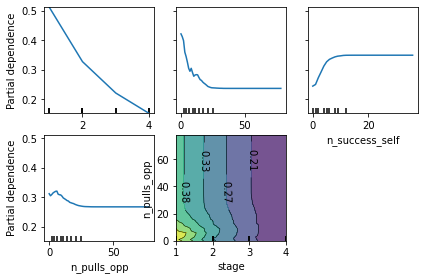

In [52]:
plot_partial_dependence(rfr, X, [0, 1, 2, 3, (0, 3)]);
plt.tight_layout()